# Overview

This is the script for Applied Data Science class project. The team performed in-depth analysis and comparison of bus speed between local and express buses. This analysis focuses on M15 and M15SBS that runs on East Manhattan.

It includes the following: 
- Load Data
- Data Processing
- Bus Speed Calculation
- Analysis
- Statistical Testing

In [70]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
#import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

#from fiona.crs import from_epsg
import shapely
from shapely.geometry import *


from geopy.distance import vincenty

---

# Load Data

- Remove Redundent Columns
- Specify DateTime Columns
- Convert time from UTC to EDT

In [2]:
def read_data(url):
    '''
    This function reads the specified data from URL, drop unwanted columns, and convert UTC to EST
    Input: url to the dataset
    Output: Pandas Dataframe of bus trip data
    
    '''
    try:
        df = pd.read_csv(url, infer_datetime_format = True)
        df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis = 1)
        df['timestamp_utc'] = pd.to_datetime(df['timestamp'])
        df['timestamp_est'] = df['timestamp_utc'] - timedelta(hours=5)
    except Exception as e:
        print(e)
        pass

    return df


# Run the Data Load Scritp
url_m15 = "./data/m15_final.csv"
url_m15sbs = "./data/m15_sbs_final.csv"

m15_df, m15sbs_df = read_data(url_m15), read_data(url_m15sbs)


In [3]:
m15_df.head()

,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,Day,Hour,DOW,DOW_Label,timestamp_utc,timestamp_est
0,2017-05-01 00:00:00,5254,40.731723,-73.985397,233.71,0,20170430,OH_B7-Sunday-113300_M15_36,1,404105,9289.01,121.04,1,0,0,Mon,2017-05-01 00:00:00,2017-04-30 19:00:00
1,2017-05-01 00:00:01,5585,40.753502,-73.966428,54.36,0,20170430,OH_B7-Sunday-115300_M15_28,1,401701,7417.29,13.53,1,0,0,Mon,2017-05-01 00:00:01,2017-04-30 19:00:01
2,2017-05-01 00:00:03,5549,40.777583,-73.948857,53.97,0,20170430,OH_B7-Sunday-113300_M15_49,1,401716,10650.91,187.72,1,0,0,Mon,2017-05-01 00:00:03,2017-04-30 19:00:03
3,2017-05-01 00:00:03,5959,40.705924,-74.006331,34.83,0,20170430,OH_B7-Sunday-119300_M15_34,1,401667,867.48,67.73,1,0,0,Mon,2017-05-01 00:00:03,2017-04-30 19:00:03
4,2017-05-01 00:00:10,5544,40.789946,-73.939831,53.84,0,20170430,OH_B7-Sunday-113400_M15_23,1,401724,10146.39,224.11,1,0,0,Mon,2017-05-01 00:00:10,2017-04-30 19:00:10


In [4]:
m15_df.shape

(645808, 18)

In [5]:
m15_df.dtypes

timestamp                   object
vehicle_id                   int64
latitude                   float64
longitude                  float64
bearing                    float64
progress                     int64
service_date                 int64
trip_id                     object
block_assigned               int64
next_stop_id                 int64
dist_along_route           float64
dist_from_stop             float64
Day                          int64
Hour                         int64
DOW                          int64
DOW_Label                   object
timestamp_utc       datetime64[ns]
timestamp_est       datetime64[ns]
dtype: object

In [21]:
m15sbs_df.head()

,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop,Day,Hour,DOW,DOW_Label,timestamp_utc,timestamp_est
0,2017-05-01 00:00:01,1260,40.778163,-73.951532,233.87,0,20170430,OF_B7-Sunday-119100_SBS15_446,1,401756,3935.60,668.81,1,0,0,Mon,2017-05-01 00:00:01,2017-04-30 19:00:01
1,2017-05-01 00:00:02,1263,40.782688,-73.945127,54.26,0,20170430,OF_B7-Sunday-114900_SBS15_449,1,903102,11361.77,258.57,1,0,0,Mon,2017-05-01 00:00:02,2017-04-30 19:00:02
2,2017-05-01 00:00:03,1257,40.738593,-73.977293,53.86,0,20170430,OF_B7-Sunday-116600_SBS15_450,1,404995,5748.06,249.92,1,0,0,Mon,2017-05-01 00:00:03,2017-04-30 19:00:03
3,2017-05-01 00:00:08,1268,40.725444,-73.989970,233.85,0,20170430,OF_B7-Sunday-113500_SBS15_461,1,803078,10214.33,248.88,1,0,0,Mon,2017-05-01 00:00:08,2017-04-30 19:00:08
4,2017-05-01 00:00:08,1272,40.724697,-73.990513,234.26,0,20170430,OF_B7-Sunday-115200_SBS15_462,1,803078,10214.33,154.07,1,0,0,Mon,2017-05-01 00:00:08,2017-04-30 19:00:08


In [61]:
m15sbs_df.shape

(645572, 18)

In [62]:
m15sbs_df.dtypes

timestamp                   object
vehicle_id                   int64
latitude                   float64
longitude                  float64
bearing                    float64
progress                     int64
service_date                 int64
trip_id                     object
block_assigned               int64
next_stop_id                 int64
dist_along_route           float64
dist_from_stop             float64
Day                          int64
Hour                         int64
DOW                          int64
DOW_Label                   object
timestamp_utc       datetime64[ns]
timestamp_est       datetime64[ns]
dtype: object

---

# Data Cleaning and Selection

- Select on Block Assignment > 0; if Block Assignment is 0, then the bus is not in service even it's runnin
- Filter out trips with less than 15 records
- create direction indicator


In [6]:
def data_processing(df):
    
    '''
    This function is the workflow of data cleaning and processing. It selects only buses in service, 
    filter out trips with enough samples, and infers the trip direction
    Input: data frame for processing
    Output: clean data frame with new columns
    '''
    
    try:
        # Select only Block Assignment > 0
        clean_df = df[df.block_assigned > 0]

        # Filter out trips with less than 15 records
        clean_df = clean_df.groupby(clean_df.trip_id).filter(lambda group: len(group) > 15)

        # Infer Direciton

        for trip_id, group in clean_df.groupby("trip_id"):
            sort = group.sort_values("timestamp")
            trip =  clean_df["trip_id"] == trip_id
            if sort.iloc[0].latitude > sort.iloc[-1].latitude:
                clean_df.loc[trip, "direction"] = 0 # southbound
            else:
                clean_df.loc[trip, "direction"] = 1 # northbound
                
    except Exception as e: 
        print(e)
        pass
            
    return clean_df

# Run the Data Processing Script
clean_m15, clean_m15sbs = data_processing(m15_df), data_processing(m15sbs_df)

In [65]:
clean_m15.shape

(645808, 19)

In [66]:
clean_m15.groupby("direction").size()

direction
0.0    351599
1.0    294209
dtype: int64

In [67]:
clean_m15sbs.groupby("direction").size()

direction
0.0    340017
1.0    305555
dtype: int64

In [57]:
len(clean_m15.groupby("trip_id"))


1416

---

# Analysis

- Calculate speed between stops
- Calculate overall trip speed
- Look at differences and test for significance

### Speed between stops

In [32]:
def get_speed_df(group):
    ordered_stops = group.drop_duplicates(subset="next_stop_id", keep="first")["next_stop_id"].as_matrix()
    first_stops = group.groupby("next_stop_id").first()
    last_stops = group.groupby("next_stop_id").last()
    
    dicts = []
    for i, cur_stop in enumerate(ordered_stops):
        d = {}
        next_stop = ordered_stops[i + 1] if (i + 1) < len(ordered_stops) else -1
        if next_stop == -1:
            continue
        try:
            prev_info = last_stops.loc[cur_stop]
            next_info = last_stops.loc[next_stop]
        except:
            print 'crap'
            continue
        
        time_between = next_info.timestamp_est - prev_info.timestamp_est
        if time_between.seconds == 0:
            return next_info, prev_info
        
        d['next_stop'] = next_stop
        d['prev_stop'] = cur_stop
        d['time_between'] = time_between
        d['dist_between'] = vincenty(next_info[["latitude", "longitude"]],
                                     prev_info[["latitude", "longitude"]]).miles
        d["mph"] = d["dist_between"]* 3600. / (d["time_between"].seconds)
        d["depart_timestamp"] = prev_info.timestamp_est
        d["arrive_timestamp"] = next_info.timestamp_est
        d["depart_lat"] = prev_info.latitude
        d["depart_lng"] = prev_info.longitude
        d["arrive_lat"] = next_info.latitude
        d["arrive_lng"] = next_info.longitude
        d["direction"] = next_info.direction
        dicts.append(d)
    speed_info = pd.DataFrame(dicts)
    return speed_info

In [39]:
def gen_interval_df(timestamps):
    by_days = timestamps.groupby("Day")
    infos = []
    for day, day_group in by_days:
        print "======="
        print "on day {}".format(day)
        by_trip = day_group.groupby("trip_id")
        for i, (ix, g) in enumerate(by_trip):
            by_vehicle = g.groupby("vehicle_id")
            if i % 100 == 0:
                print i
            for vehicle, v_group in by_vehicle:
                if len(v_group) < 15:
                    continue
                info = get_speed_df(v_group)
                if isinstance(info, tuple):
                    print "BREAK!!!!!"
                    return info
                info["trip_id"] = ix
                info["day"] = day
                info["vehicle"] = vehicle
                infos.append(info)
    final = pd.concat(infos)
    return final

clean_m15sbs.sort_values("timestamp_est", inplace=True)
clean_m15.sort_values("timestamp_est", inplace=True)
final_intervals_m15sbs = gen_interval_df(clean_m15sbs)
final_intervals_m15 = gen_interval_df(clean_m15)

on day 1
0
100
200
300
on day 2
0
100
200
300
on day 3
0
100
200
300
on day 4
0
100
200
300
on day 5
0
100
200
300
on day 6
0
100
200
on day 7
0
100
200
on day 8
0
100
200
300
on day 9
0
100
200
300
on day 10
0
100
200
300
on day 11
0
100
200
300
on day 12
0
100
200
300
on day 13
0
100
200
on day 14
0
100
200
on day 15
0
100
200
300
on day 16
0
100
200
300
on day 17
0
100
200
300
on day 18
0
100
200
300
on day 19
0
100
200
300
on day 20
0
100
200
on day 21
0
100
200
on day 22
0
100
200
300
on day 23
0
100
200
300
on day 24
0
100
200
300
on day 25
0
100
200
300
on day 26
0
100
200
300
on day 27
0
100
200
on day 28
0
100
on day 29
0
100
on day 30
0
100
200
300
on day 31
0
100
200
300
on day 1
0
100
200
on day 2
0
100
200
on day 3
0
100
200
on day 4
0
100
200
on day 5
0
100
200
on day 6
0
100
200
on day 7
0
100
200
on day 8
0
100
200
on day 9
0
100
200
on day 10
0
100
200
on day 11
0
100
200
on day 12
0
100
200
on day 13
0
100
200
on day 14
0
100
200
on day 15
0
100
200
on day 16
0
100
20

In [40]:
final_intervals_m15.to_csv("./data/m15_final_interval.csv")
final_intervals_m15sbs.to_csv("./data/m15sbs_final_interval.csv")

## Overall Speed

In [122]:
def total_mph(last, first):
    secs = (last.arrive_timestamp - first.depart_timestamp).seconds
    dist = vincenty(last[["arrive_lat", "arrive_lng"]],
                    first[["depart_lat", "depart_lng"]]).miles
    return dist * 3600. / secs
    
overall_speeds_reg = final_intervals_m15.groupby(["day", "trip_id", "direction", "vehicle"]).apply(lambda g: total_mph(g.iloc[-1], g.iloc[0]))
overall_speeds_sbs = final_intervals_m15sbs.groupby(["day", "trip_id", "direction", "vehicle"]).apply(lambda g: total_mph(g.iloc[-1], g.iloc[0]))

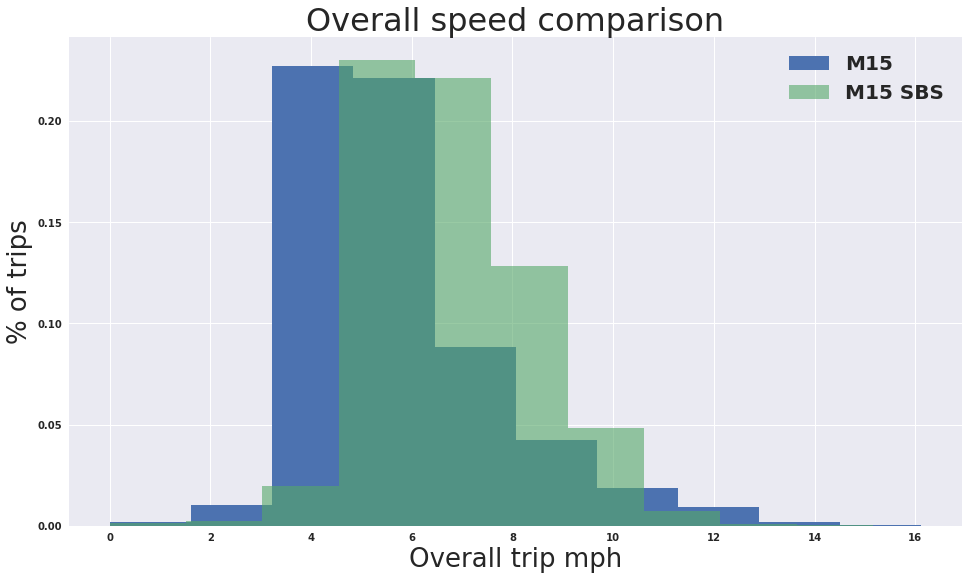

In [123]:
ax = overall_speeds_reg.hist(figsize=(16,9), label="M15", normed=True)
ax = overall_speeds_sbs.hist(ax=ax, alpha=.6, label="M15 SBS", normed=True)
ax.set_ylabel("% of trips", fontsize=26)
ax.set_xlabel("Overall trip mph", fontsize=26)
ax.set_title("Overall speed comparison", fontsize=32)
ax.legend(fontsize=20)

## Significance tests

In [124]:
import scipy.stats as sps
print "regular mean: {}".format(overall_speeds_reg.mean())
print "SBS mean: {}".format(overall_speeds_sbs.mean())
print "P-value: {}".format(sps.ttest_ind(overall_speeds_reg, overall_speeds_sbs, equal_var=False).pvalue)

regular mean: 5.70674729258
SBS mean: 6.76213080967
P-value: 0.0


## Further analysis
### Look at northbound / southbound trips

northbound mean: 6.38731956615
southbound mean: 5.05303059497
P-value: 3.88143931857e-220


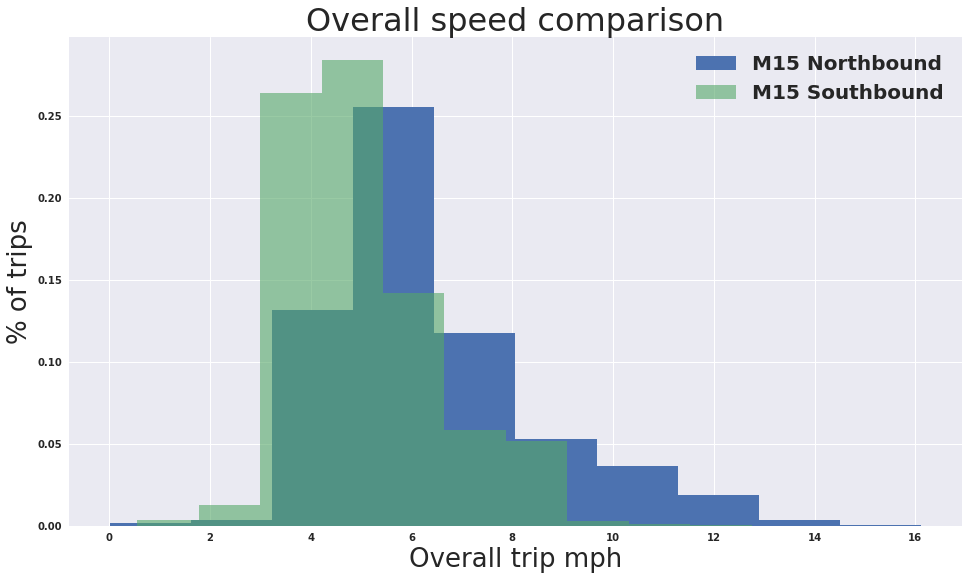

In [130]:
overall_speeds_reg_s = overall_speeds_reg.loc[:, :, 0, :]
overall_speeds_reg_n = overall_speeds_reg.loc[:, :, 1, :]
overall_speeds_sbs_n = overall_speeds_sbs.loc[:, :, 1, :]
overall_speeds_sbs_s = overall_speeds_sbs.loc[:, :, 0, :]

ax = overall_speeds_reg_n.hist(figsize=(16,9), label="M15 Northbound", normed=True)
ax = overall_speeds_reg_s.hist(ax=ax, alpha=.6, label="M15 Southbound", normed=True)
ax.set_ylabel("% of trips", fontsize=26)
ax.set_xlabel("Overall trip mph", fontsize=26)
ax.set_title("Overall speed comparison", fontsize=32)
ax.legend(fontsize=20)

print "northbound mean: {}".format(overall_speeds_reg_n.mean())
print "southbound mean: {}".format(overall_speeds_reg_s.mean())
print "P-value: {}".format(sps.ttest_ind(overall_speeds_reg_n, overall_speeds_reg_s, equal_var=False).pvalue)

northbound mean: 7.26750837232
southbound mean: 6.26094542064
P-value: 3.88203344966e-218


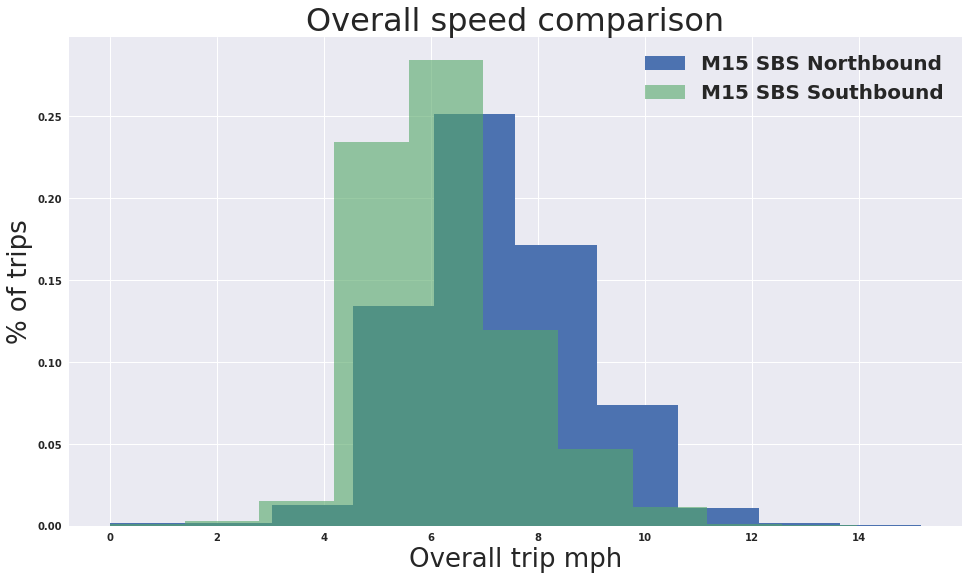

In [131]:
ax = overall_speeds_sbs_n.hist(figsize=(16,9), label="M15 SBS Northbound", normed=True)
ax = overall_speeds_sbs_s.hist(ax=ax, alpha=.6, label="M15 SBS Southbound", normed=True)
ax.set_ylabel("% of trips", fontsize=26)
ax.set_xlabel("Overall trip mph", fontsize=26)
ax.set_title("Overall speed comparison", fontsize=32)
ax.legend(fontsize=20)

print "northbound mean: {}".format(overall_speeds_sbs_n.mean())
print "southbound mean: {}".format(overall_speeds_sbs_s.mean())
print "P-value: {}".format(sps.ttest_ind(overall_speeds_sbs_n, overall_speeds_sbs_s, equal_var=False).pvalue)

## Look at hour of trip departure

In [135]:
start_hours_m15 = final_intervals_m15.groupby(["day", "trip_id", "direction", "vehicle"]).apply(lambda g: g.iloc[0].depart_timestamp.hour)
start_hours_sbs = final_intervals_m15sbs.groupby(["day", "trip_id", "direction", "vehicle"]).apply(lambda g: g.iloc[0].depart_timestamp.hour)

In [149]:
overall_speeds_reg_hours = start_hours_m15.to_frame().join(overall_speeds_reg.to_frame(), lsuffix="h_")
overall_speeds_sbs_hours = start_hours_sbs.to_frame().join(overall_speeds_sbs.to_frame(), lsuffix="h_")
overall_speeds_reg_hours.columns = ["Hour of Day", "M15 Speed"]
overall_speeds_sbs_hours.columns = ["Hour of Day", "M15 SBS Speed"]

Text(0.5,1,u'Average Trip Speed by hour of day')

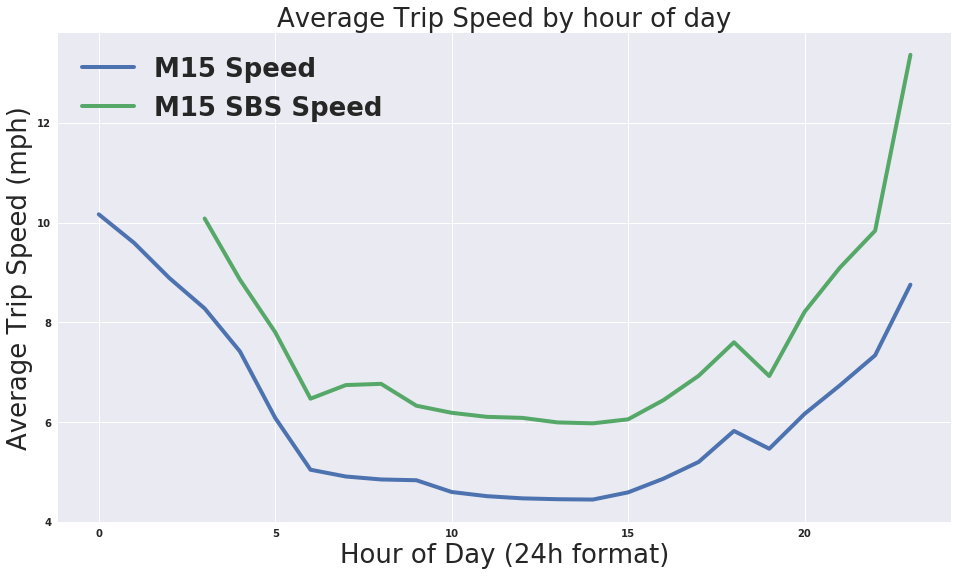

In [157]:
ax = overall_speeds_reg_hours.groupby("Hour of Day").mean().plot(figsize=(16, 9), linewidth=4)
overall_speeds_sbs_hours.groupby("Hour of Day").mean().plot(ax=ax, linewidth=4)
ax.legend(fontsize=26)
ax.set_xlabel("Hour of Day (24h format)", fontsize=26)
ax.set_ylabel("Average Trip Speed (mph)", fontsize=26)
ax.set_title("Average Trip Speed by hour of day", fontsize=26)

In [189]:
from itertools import izip
overall_speeds_reg_hours.sort_values("Hour of Day", inplace=True)
overall_speeds_sbs_hours.sort_values("Hour of Day", inplace=True)

for (ix, reg_group), (ix2, sbs_group) in izip(overall_speeds_reg_hours[(overall_speeds_reg_hours["Hour of Day"] > 2) & (overall_speeds_reg_hours["Hour of Day"] < 23)].groupby("Hour of Day"), overall_speeds_sbs_hours.groupby("Hour of Day")):
    reg_speed =  reg_group["M15 Speed"]
    sbs_speed = sbs_group["M15 SBS Speed"]
    if ix == 23:
        r = reg_speed
        s = sbs_speed
        break
    print "regular speed at hour {}: {}".format(ix, reg_speed.mean())
    print "SBS speed at hour {}: {}".format(ix2, sbs_speed.mean())
    print "p-value: {}".format(sps.ttest_ind(reg_speed, sbs_speed, equal_var=False).pvalue)
    print "==================="
    

regular speed at hour 3: 8.27759363783
SBS speed at hour 3: 10.0809254732
p-value: 2.29342369348e-15
regular speed at hour 4: 7.41594164061
SBS speed at hour 4: 8.85486176532
p-value: 5.10919438787e-36
regular speed at hour 5: 6.08351473331
SBS speed at hour 5: 7.80086179888
p-value: 5.58504954953e-92
regular speed at hour 6: 5.04471187182
SBS speed at hour 6: 6.46904395423
p-value: 2.47711484946e-82
regular speed at hour 7: 4.9087929059
SBS speed at hour 7: 6.74157374042
p-value: 1.54021728642e-83
regular speed at hour 8: 4.84937168146
SBS speed at hour 8: 6.7663831205
p-value: 2.70314456305e-96
regular speed at hour 9: 4.83390092269
SBS speed at hour 9: 6.32796778093
p-value: 1.59532097357e-78
regular speed at hour 10: 4.59810246088
SBS speed at hour 10: 6.18581201051
p-value: 8.81073617563e-80
regular speed at hour 11: 4.51433369931
SBS speed at hour 11: 6.10471391579
p-value: 1.46512750405e-89
regular speed at hour 12: 4.47092612193
SBS speed at hour 12: 6.08434298026
p-value: 1.73

Text(0.5,1,u'Average Trip Speed by hour of day')

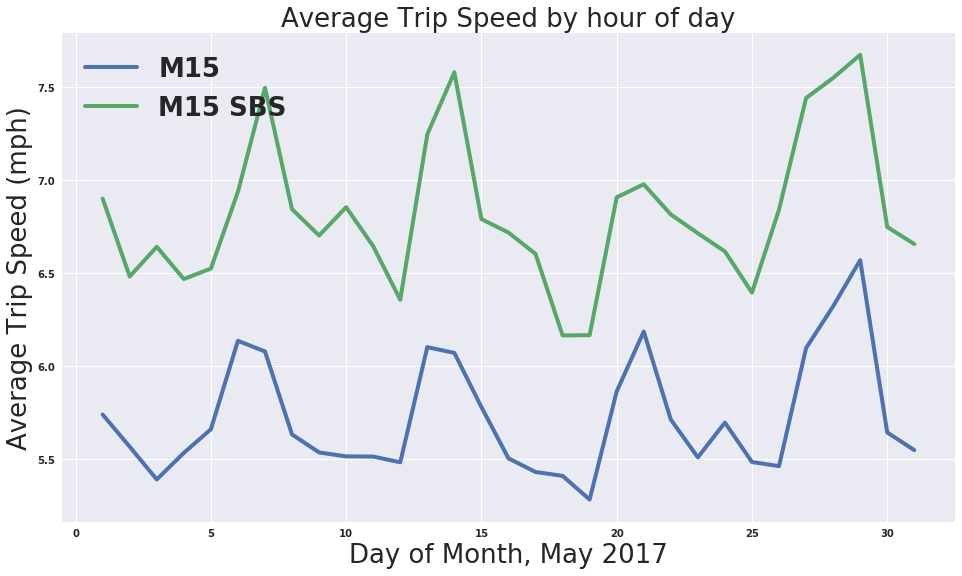

In [200]:
overall_speeds_reg.groupby(level=0).mean()
overall_speeds_sbs.groupby(level=0).mean()

ax = overall_speeds_reg.groupby(level=0).mean().plot(figsize=(16, 9), linewidth=4, label="M15")
overall_speeds_sbs.groupby(level=0).mean().plot(ax=ax, linewidth=4, label="M15 SBS")
ax.legend(fontsize=26)
ax.set_xlabel("Day of Month, May 2017", fontsize=26)
ax.set_ylabel("Average Trip Speed (mph)", fontsize=26)
ax.set_title("Average Trip Speed by hour of day", fontsize=26)

## This concludes our analysis